In [33]:
import math, json, random
from dataclasses import dataclass
from typing import Tuple, List

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt

In [34]:
@dataclass
class Config:
    csv_path: str = "toothy_dataset.csv"
    target_col: str = "teeth_section"      # int in [1..9]
    feature_cols: Tuple[str, ...] = (
        "tb_mid_x","tb_mid_y",
        "hw_x","hw_y",
        "hm_x","hm_y",
        "ht_x","ht_y",
        "is_smiling",
    )
    use_relative_diffs: bool = False   # set True to add a few (x,y) differences
    seed: int = 42
    batch_size: int = 64
    lr: float = 1e-3
    weight_decay: float = 1e-4
    hidden_sizes: Tuple[int, ...] = (64, 32)  # small net
    dropout: float = 0.10
    max_epochs: int = 150
    patience: int = 20
    num_folds: int = 5
    save_final_model: bool = True
    final_model_path: str = "brushing_mlp.pt"
    final_scaler_path: str = "brushing_scaler.json"

cfg = Config()

In [35]:
def set_seed(seed: int):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [36]:
def featurize_row(r, use_relative: bool) -> List[float]:
    # Already mouth-centered: (0,0) is mouth
    tbx, tby = r["tb_mid_x"], r["tb_mid_y"]
    hwx, hwy = r["hw_x"], r["hw_y"]
    hmx, hmy = r["hm_x"], r["hm_y"]
    htx, hty = r["ht_x"], r["ht_y"]
    smile    = r["is_smiling"]  # 1=smile/closed, 0=open

    feats = [
        tbx, tby,
        hwx, hwy,
        hmx, hmy,
        htx, hty,
        float(smile),
    ]

    if use_relative:
        # A tiny boost (still no angles/scale normalization):
        # TB relative to each hand point, and hand chain vectors
        feats += [
            tbx - hwx, tby - hwy,
            tbx - hmx, tby - hmy,
            tbx - htx, tby - hty,
            hmx - hwx, hmy - hwy,   # wrist->middle
            htx - hmx, hty - hmy,   # middle->tips
        ]

    return feats

In [37]:
def build_Xy(df: pd.DataFrame, use_relative: bool):
    X = np.vstack([featurize_row(r, use_relative) for _, r in df.iterrows()]).astype(np.float32)
    y = df[cfg.target_col].astype(int).values - 1  # to 0..8
    return X, y

In [38]:
class MLP(nn.Module):
    def __init__(self, in_dim: int, hidden: Tuple[int, ...], num_classes: int, dropout: float):
        super().__init__()
        layers = []
        prev = in_dim
        for h in hidden:
            layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, num_classes)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [39]:
def run_cv(X, y, cfg: Config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    skf = StratifiedKFold(n_splits=cfg.num_folds, shuffle=True, random_state=cfg.seed)

    all_metrics = []
    fold_states = []  # store best state + scaler per fold for optional final fitting ideas

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_va, y_va = X[va_idx], y[va_idx]

        scaler = StandardScaler()
        X_tr = scaler.fit_transform(X_tr)
        X_va = scaler.transform(X_va)

        tr_ds = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr))
        va_ds = TensorDataset(torch.from_numpy(X_va), torch.from_numpy(y_va))
        tr_dl = DataLoader(tr_ds, batch_size=cfg.batch_size, shuffle=True)
        va_dl = DataLoader(va_ds, batch_size=cfg.batch_size, shuffle=False)

        model = MLP(in_dim=X.shape[1], hidden=cfg.hidden_sizes, num_classes=9, dropout=cfg.dropout).to(device)

        # Class weights (handle imbalance)
        class_counts = np.bincount(y_tr, minlength=9)
        inv = 1.0 / np.maximum(class_counts, 1)
        weights = inv / inv.sum() * 9
        criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float32, device=device))

        optim = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

        best_val = float("inf")
        best_state = None
        patience_left = cfg.patience

        train_losses = []
        val_losses = []

        for epoch in range(1, cfg.max_epochs + 1):
            # train
            model.train()
            epoch_loss = 0.0
            for xb, yb in tr_dl:
                xb, yb = xb.to(device), yb.to(device)
                optim.zero_grad()
                logits = model(xb)
                loss = criterion(logits, yb)
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optim.step()
                epoch_loss += loss.item() * xb.size(0)
            train_losses.append(epoch_loss / len(tr_ds))

            # val
            model.eval()
            val_loss = 0.0
            preds, gts = [], []
            with torch.no_grad():
                for xb, yb in va_dl:
                    xb, yb = xb.to(device), yb.to(device)
                    logits = model(xb)
                    loss = criterion(logits, yb)
                    val_loss += loss.item() * xb.size(0)
                    preds.append(logits.argmax(1).cpu().numpy())
                    gts.append(yb.cpu().numpy())
            val_loss /= len(va_ds)
            val_losses.append(val_loss)
            preds = np.concatenate(preds); gts = np.concatenate(gts)

            if val_loss < best_val - 1e-6:
                best_val = val_loss
                patience_left = cfg.patience
                best_state = {
                    "model": model.state_dict(),
                    "scaler_mean": scaler.mean_.tolist(),
                    "scaler_scale": scaler.scale_.tolist(),
                }
            else:
                patience_left -= 1
                if patience_left <= 0:
                    break

        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Fold {fold} Loss Curve")
        plt.legend()
        plt.show()

        # final eval on best
        model.load_state_dict(best_state["model"])
        scaler.mean_ = np.array(best_state["scaler_mean"])
        scaler.scale_ = np.array(best_state["scaler_scale"])

        model.eval()
        va_dl = DataLoader(va_ds, batch_size=cfg.batch_size, shuffle=False)
        preds = []
        with torch.no_grad():
            for xb, _ in va_dl:
                xb = xb.to(device)
                logits = model(xb)
                preds.append(logits.argmax(1).cpu().numpy())
        preds = np.concatenate(preds)

        acc = accuracy_score(gts, preds)
        f1m = f1_score(gts, preds, average="macro")
        cm = confusion_matrix(gts, preds, labels=list(range(9)))
        report = classification_report(
            gts, preds, labels=list(range(9)), digits=3,
            target_names=[
                "closed_left","closed_mid","closed_right",
                "open_left_down","open_mid_down","open_right_down",
                "open_left_up","open_mid_up","open_right_up"
            ]
        )

        print(f"\n=== Fold {fold} ===")
        print(f"Val Acc: {acc:.3f} | Val Macro-F1: {f1m:.3f}")
        print("Confusion Matrix (rows=true, cols=pred):")
        print(cm)
        print("Per-class report:\n" + report)

        all_metrics.append({"fold": fold, "val_acc": acc, "val_f1_macro": f1m})
        fold_states.append(best_state)

    print("\n=== CV Summary ===")
    mean_acc = np.mean([m["val_acc"] for m in all_metrics])
    mean_f1  = np.mean([m["val_f1_macro"] for m in all_metrics])
    print(f"Mean Acc: {mean_acc:.3f} | Mean Macro-F1: {mean_f1:.3f}")

    return fold_states

In [40]:
def fit_all_and_save(X, y, cfg: Config):
    """Train on ALL data once and save model + scaler."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    ds = TensorDataset(torch.from_numpy(Xs), torch.from_numpy(y))
    dl = DataLoader(ds, batch_size=cfg.batch_size, shuffle=True)

    model = MLP(in_dim=X.shape[1], hidden=cfg.hidden_sizes, num_classes=9, dropout=cfg.dropout).to(device)

    class_counts = np.bincount(y, minlength=9)
    inv = 1.0 / np.maximum(class_counts, 1)
    weights = inv / inv.sum() * 9
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float32, device=device))
    optim = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    best_loss = float("inf"); patience_left = cfg.patience; best_state = None

    for epoch in range(1, cfg.max_epochs + 1):
        model.train()
        epoch_loss = 0.0
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            optim.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optim.step()
            epoch_loss += loss.item() * xb.size(0)
        epoch_loss /= len(ds)

        if epoch_loss < best_loss - 1e-6:
            best_loss = epoch_loss
            patience_left = cfg.patience
            best_state = model.state_dict()
        else:
            patience_left -= 1
            if patience_left <= 0:
                break

    model.load_state_dict(best_state)

    if cfg.save_final_model:
        torch.save(model.state_dict(), cfg.final_model_path)
        with open(cfg.final_scaler_path, "w") as f:
            json.dump({"mean": scaler.mean_.tolist(), "scale": scaler.scale_.tolist()}, f, indent=2)
        print(f"\nSaved model -> {cfg.final_model_path}")
        print(f"Saved scaler -> {cfg.final_scaler_path}")

    return model, scaler

In [41]:
def main():
    set_seed(cfg.seed)
    df = pd.read_csv(cfg.csv_path)
    need = set(cfg.feature_cols) | {cfg.target_col}
    miss = [c for c in need if c not in df.columns]
    if miss:
        raise ValueError(f"Missing columns in CSV: {miss}")
    df = df.dropna(subset=list(need)).reset_index(drop=True)

    X, y = build_Xy(df, cfg.use_relative_diffs)
    print(f"Samples: {len(y)} | Features per sample: {X.shape[1]}")

    # Cross-validated training & evaluation
    _ = run_cv(X, y, cfg)

    # Fit on all data and save (for deployment/inference)
    fit_all_and_save(X, y, cfg)

Samples: 436 | Features per sample: 9


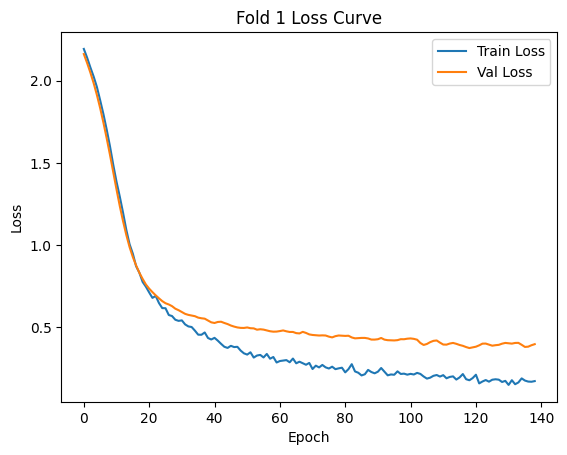


=== Fold 1 ===
Val Acc: 0.898 | Val Macro-F1: 0.905
Confusion Matrix (rows=true, cols=pred):
[[ 7  0  0  0  0  0  0  0  0]
 [ 0  8  1  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  0]
 [ 0  0  0  8  0  1  0  0  0]
 [ 0  0  0  0 12  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  1]
 [ 0  0  0  0  1  0  8  0  1]
 [ 0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  4  0  8]]
Per-class report:
                 precision    recall  f1-score   support

    closed_left      1.000     1.000     1.000         7
     closed_mid      1.000     0.889     0.941         9
   closed_right      0.900     1.000     0.947         9
 open_left_down      1.000     0.889     0.941         9
  open_mid_down      0.923     1.000     0.960        12
open_right_down      0.900     0.900     0.900        10
   open_left_up      0.667     0.800     0.727        10
    open_mid_up      1.000     1.000     1.000        10
  open_right_up      0.800     0.667     0.727        12

       accuracy                          0.89

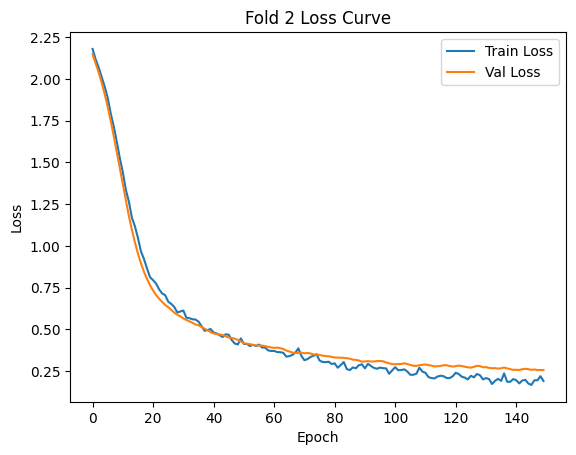


=== Fold 2 ===
Val Acc: 0.920 | Val Macro-F1: 0.921
Confusion Matrix (rows=true, cols=pred):
[[ 6  0  0  0  0  0  1  0  0]
 [ 0  8  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0]
 [ 0  0  0  8  0  1  0  0  0]
 [ 0  0  0  0 11  1  0  0  0]
 [ 0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  3  1  7]]
Per-class report:
                 precision    recall  f1-score   support

    closed_left      1.000     0.857     0.923         7
     closed_mid      1.000     1.000     1.000         8
   closed_right      1.000     1.000     1.000        10
 open_left_down      1.000     0.889     0.941         9
  open_mid_down      1.000     0.917     0.957        12
open_right_down      0.833     1.000     0.909        10
   open_left_up      0.714     1.000     0.833        10
    open_mid_up      0.909     1.000     0.952        10
  open_right_up      1.000     0.636     0.778        11

       accuracy                          0.92

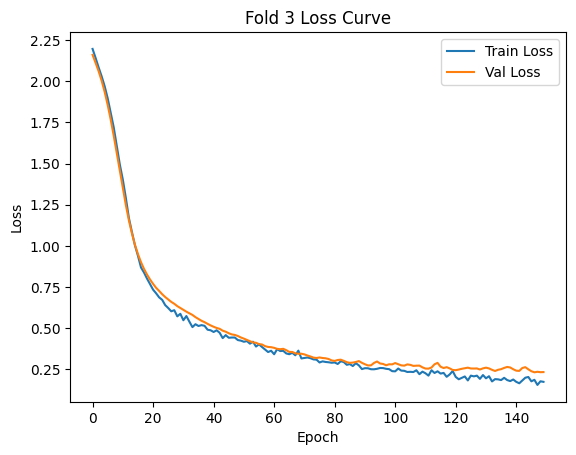


=== Fold 3 ===
Val Acc: 0.897 | Val Macro-F1: 0.896
Confusion Matrix (rows=true, cols=pred):
[[ 6  1  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0]
 [ 0  1  9  0  0  0  0  0  0]
 [ 0  0  0  7  0  2  0  0  0]
 [ 0  0  0  0 11  0  0  1  0]
 [ 0  0  0  1  0  9  0  0  0]
 [ 0  0  0  0  0  0  8  0  2]
 [ 0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  1  0 10]]
Per-class report:
                 precision    recall  f1-score   support

    closed_left      1.000     0.857     0.923         7
     closed_mid      0.800     1.000     0.889         8
   closed_right      1.000     0.900     0.947        10
 open_left_down      0.875     0.778     0.824         9
  open_mid_down      1.000     0.917     0.957        12
open_right_down      0.818     0.900     0.857        10
   open_left_up      0.889     0.800     0.842        10
    open_mid_up      0.909     1.000     0.952        10
  open_right_up      0.833     0.909     0.870        11

       accuracy                          0.89

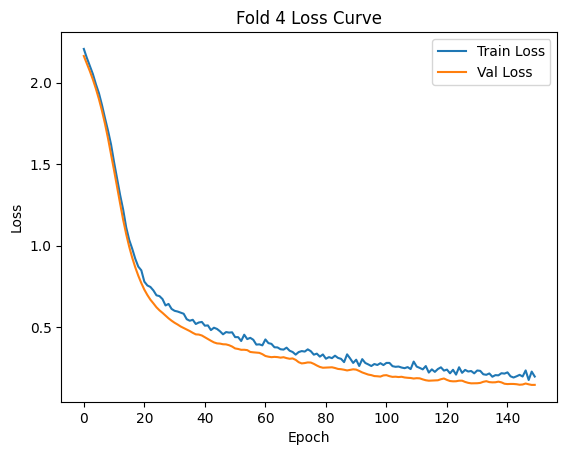


=== Fold 4 ===
Val Acc: 0.954 | Val Macro-F1: 0.956
Confusion Matrix (rows=true, cols=pred):
[[ 7  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0]
 [ 0  0  0  1  0  9  0  0  0]
 [ 0  0  0  0  0  0  8  0  1]
 [ 0  0  0  0  0  0  0 11  0]
 [ 0  0  0  0  0  0  1  1  9]]
Per-class report:
                 precision    recall  f1-score   support

    closed_left      1.000     1.000     1.000         7
     closed_mid      1.000     1.000     1.000         8
   closed_right      1.000     1.000     1.000         9
 open_left_down      0.909     1.000     0.952        10
  open_mid_down      1.000     1.000     1.000        12
open_right_down      1.000     0.900     0.947        10
   open_left_up      0.889     0.889     0.889         9
    open_mid_up      0.917     1.000     0.957        11
  open_right_up      0.900     0.818     0.857        11

       accuracy                          0.95

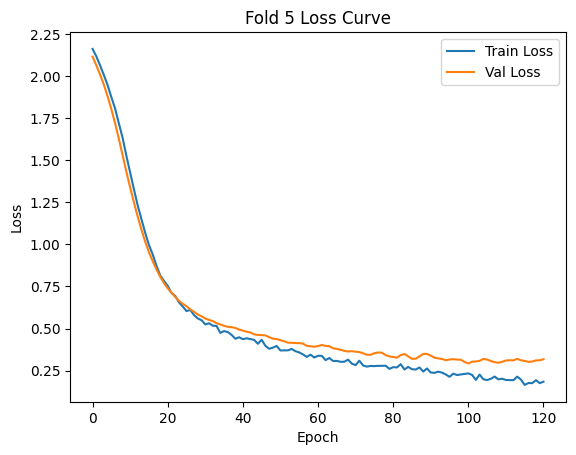


=== Fold 5 ===
Val Acc: 0.920 | Val Macro-F1: 0.912
Confusion Matrix (rows=true, cols=pred):
[[ 6  0  0  0  0  0  0  0  0]
 [ 0  8  1  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0]
 [ 0  0  0  4  1  4  0  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  1 11]]
Per-class report:
                 precision    recall  f1-score   support

    closed_left      1.000     1.000     1.000         6
     closed_mid      1.000     0.889     0.941         9
   closed_right      0.900     1.000     0.947         9
 open_left_down      0.714     1.000     0.833        10
  open_mid_down      0.923     1.000     0.960        12
open_right_down      1.000     0.444     0.615         9
   open_left_up      1.000     1.000     1.000        10
    open_mid_up      0.909     1.000     0.952        10
  open_right_up      1.000     0.917     0.957        12

       accuracy                          0.92

In [42]:
main()